## **Using the calcium monitor in the Mouse TVB**
###### *Núria Tort-Colet*

#### Install (if necessary) some dependencies

In [1]:
%%capture --no-display
!pip install moviepy
#!pip install --upgrade tvb-library
#!pip install --upgrade tvb-dataimport os
import sys
sys.path.append('tvb-root/scientific_library')
sys.path.append('tvb-root/tvb_build')

#### Import Mouse-TVB files and other tools

In [1]:

## Import TVB files:

from tvb_model_reference.simulation_file.parameter.nuu_parameter_Mouse_512 import Parameter
parameters = Parameter()

import tvb_model_reference.src.nuu_tools_simulation as tools
from tvb_model_reference.view.plot import multiview, multiview_one, prepare_surface_regions, animation_nuu

## Import tools:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from IPython.display import Video
 

/Users/nuuria/ownCloud/TVB_models/new/tvb-root/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


INFO: this monitors.py version includes a calcium monitor


#### Plot one region in the cortical surface

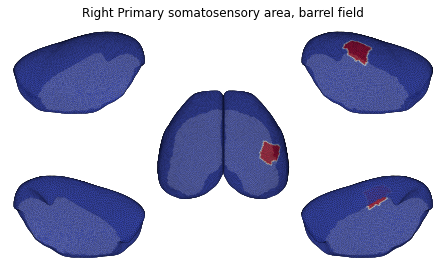

In [4]:

## Highlight one of the cortical regions of the model:

# prepare surface plot:
region_mapping, cortex, conn, hemispheres_left, hemispheres_right = \
prepare_surface_regions(parameters, 
                        h5_filename='Connectivity_nuria_v1.h5', 
                        zip_filename= 'Cortex.zip', 
                        vertices_to_region_filename = 'vertices_to_region.npy', 
                        region_map_filename = 'region_map.txt')


# chose a region by its name or by region number: (find all names at conn.region_labels)
id_region = 260
region_name = conn.region_labels[id_region]


# plot the region
the_data = np.zeros((region_mapping.array_data.shape[0],))
multiview_one(cortex, hemispheres_left, hemispheres_right, [id_region], the_data, plt.figure(), suptitle='', title=region_name, figsize=(8, 8), shaded=False)


In [5]:
print(conn.region_labels[0:10])

['Left Frontal pole, cerebral cortex' 'Left Primary motor area'
 'Left Secondary motor area' 'Left Primary somatosensory area, nose'
 'Left Primary somatosensory area, barrel field'
 'Left Primary somatosensory area, lower limb'
 'Left Primary somatosensory area, mouth'
 'Left Primary somatosensory area, upper limb'
 'Left Primary somatosensory area, trunk'
 'Left Primary somatosensory area, unassigned']


#### Set up the parameters of the simulation

In [6]:

## Set the parameters of the simulation:

run_sim = 5000.0 # ms, length of the simulation
cut_transient = 2000.0 # ms, length of the discarded initial segment

bvals = [0,60] # List of values of adaptation strength which will vary the brain state
simname = ['asynchronous','synchronous']
Iext = 0.000315 # External input


## Set the parameters of the stimulus (choose stimval = 0 to simulate spontaneous activity)

stimval = 0 #  stimulus strength
stimdur = 50 # ms, duration of the stimulus
stimtime_mean = 2500. # ms, time after simulation start (it will be shufled)
stim_region = 260 # Right barrel field in the primary somatosensory area of the cortex.
# stim_region = 350 # Right VPM nucleus of the thalamus.




#### Define a location to save the simulations

In [7]:

## Define a location to save the files; create the folder if necessary:

folder_root = './result/brain_states/'

try:
    os.listdir(folder_root)
except:
    os.mkdir(folder_root)
    

#### Set up the simulator

In [8]:

## Set up the simulator:


simulator = tools.init(parameters.parameter_simulation,
                          parameters.parameter_model,
                          parameters.parameter_connection_between_region,
                          parameters.parameter_coupling,
                          parameters.parameter_integrator,
                          parameters.parameter_monitor)


In [2]:
parameters.parameter_model


{'matteo': False,
 'order': 2,
 'g_L': 10.0,
 'E_L_e': -63.0,
 'E_L_i': -65.0,
 'C_m': 200.0,
 'b_e': 60.0,
 'a_e': 0.0,
 'b_i': 0.0,
 'a_i': 0.0,
 'tau_w_e': 500.0,
 'tau_w_i': 1.0,
 'E_e': 0.0,
 'E_i': -80.0,
 'Q_e': 1.5,
 'Q_i': 5.0,
 'tau_e': 5.0,
 'tau_i': 5.0,
 'N_tot': 10000,
 'p_connect_e': 0.05,
 'p_connect_i': 0.05,
 'g': 0.2,
 'T': 40.0,
 'P_e': [-0.0498,
  0.00506,
  -0.025,
  0.0014,
  -0.00041,
  0.0105,
  -0.036,
  0.0074,
  0.0012,
  -0.0407],
 'P_i': [-0.0514,
  0.004,
  -0.0083,
  0.0002,
  -0.0005,
  0.0014,
  -0.0146,
  0.0045,
  0.0028,
  -0.0153],
 'external_input_ex_ex': 0.000315,
 'external_input_ex_in': 0.0,
 'external_input_in_ex': 0.000315,
 'external_input_in_in': 0.0,
 'tau_OU': 5.0,
 'weight_noise': 0.0001,
 'K_ext_e': 400,
 'K_ext_i': 0,
 'initial_condition': {'E': [0.0, 0.0],
  'I': [0.0, 0.0],
  'C_ee': [0.0, 0.0],
  'C_ei': [0.0, 0.0],
  'C_ii': [0.0, 0.0],
  'W_e': [100.0, 100.0],
  'W_i': [0.0, 0.0],
  'noise': [0.0, 0.0]}}

#### Run simulation (it takes a while)

In [10]:

## Don't run this cell if you already have the simulation files stored
    
for simnum in range(len(bvals)):
    parameters.parameter_model['b_e'] = bvals[simnum] 

    parameters.parameter_model['external_input_ex_ex']=Iext
    parameters.parameter_model['external_input_in_ex']=Iext

    weight = list(np.zeros(simulator.number_of_nodes))
    weight[stim_region] = stimval # region and stimulation strength of the region 0 

    parameters.parameter_stimulus["tau"]= stimdur # stimulus duration [ms]
    parameters.parameter_stimulus["T"]= 1e9 # interstimulus interval [ms]
    parameters.parameter_stimulus["weights"]= weight
    parameters.parameter_stimulus["variables"]=[0] #variable to kick


    print('b_e =',bvals[simnum])


    parameters.parameter_stimulus['onset'] = cut_transient + 0.5*(run_sim-cut_transient)
    stim_time = parameters.parameter_stimulus['onset']
    stim_steps = stim_time*10 #number of steps until stimulus

    parameters.parameter_simulation['path_result'] = folder_root +'_b_'+str(bvals[simnum])+'/'
    simulator = tools.init(parameters.parameter_simulation,
                          parameters.parameter_model,
                          parameters.parameter_connection_between_region,
                          parameters.parameter_coupling,
                          parameters.parameter_integrator,
                          parameters.parameter_monitor,
                          parameter_stimulation=parameters.parameter_stimulus)
    if stimval:
        print ('    Stimulating for {1} ms, {2} nS in the {0}\n'.format(simulator.connectivity.region_labels[stim_region],parameters.parameter_stimulus['tau'],stimval))

    tools.run_simulation(simulator,
                run_sim,                            
                parameters.parameter_simulation,
                parameters.parameter_monitor)
                  

b_e = 0
simulation time :1000.0


/Users/nuuria/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0
b_e = 60
simulation time :1000.0
simulation time :2000.0
simulation time :3000.0
simulation time :4000.0
simulation time :5000.0


#### Load simulation results

In [10]:

## Load simulation variables:

Ca_exc = []
Ca_inh = []

for simnum in range(len(bvals)):

    '''load result'''
    sim_name = '_b_'+str(bvals[simnum])+'/'
    print ('... loading file: ' + sim_name)       
    file_name =  folder_root + sim_name
    result = tools.get_result(file_name,cut_transient,run_sim)
            
    '''fill variables'''
    time_s = result[0][0]*1e-3 #from ms to sec
    Ca_exc.append(result[0][1][:,0,:]) # Excitatory calcium signal
    Ca_inh.append(result[0][1][:,1,:]) # Inhibitory calcium signal



... loading file: _b_0/
... loading file: _b_60/


In [11]:

## Check shape of variables: [times, regions]:

np.shape(Ca_exc[0]) # [0] for b=0pA; [1] for b=60pA

(30000, 512)

### Plot simulated time series

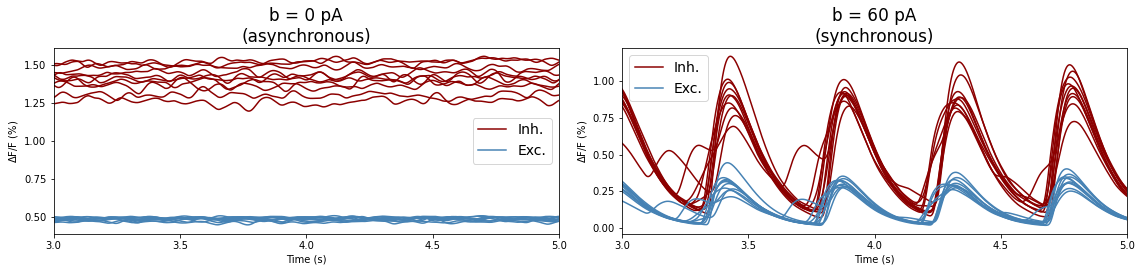

In [12]:
#%% plot simulation results for each b value:

fig, axes = plt.subplots(1,2,figsize=(16,4))
plt.rcParams.update({'font.size': 14})

for simnum in range(len(bvals)):

    '''plot traces'''
    Li = axes[simnum].plot(time_s,Ca_inh[simnum][:,0:10],color='darkred') # [times, regions]
    Le = axes[simnum].plot(time_s,Ca_exc[simnum][:,0:10],color='SteelBlue') # [times, regions]

    axes[simnum].set_xlabel('Time (s)')

    axes[simnum].set_ylabel(f'$\Delta$F/F (%)')
    
    axes[simnum].set_title('b = {0} pA\n({1})'.format(bvals[simnum],simname[simnum]))
    #axes[simnum].set_ylim([-0.25,2])
    axes[simnum].legend([Li[0], Le[0]], ['Inh.','Exc.'], loc='best')
    
    for ax in axes.reshape(-1):
        ax.set_xlim([3,5])
        ax.set_xticks([3,3.5,4,4.5,5])

plt.tight_layout()
plt.show()


### Make a movie of each brain state

If it keeps crushing skip redoing frames by setting *use_old* = **True**

In [14]:
# prepare surface plot:
region_mapping, cortex, conn, hemispheres_left, hemispheres_right = prepare_surface_regions(parameters, h5_filename='Connectivity_nuria_v1.h5', zip_filename= 'Cortex.zip', vertices_to_region_filename = 'vertices_to_region.npy', region_map_filename = 'region_map.txt')


for simnum in range(len(bvals)):

    factor = 200
    data = []
    for i, values in enumerate(Ca_exc[simnum]): # for each time sample a vector of region values
        if  i % factor == 0:
            data.append(values[cortex.region_mapping])

    print ( len(data)*0.1*factor,'ms')        
    animation_nuu(cortex,hemispheres_left,hemispheres_right, data, 
                  file_name='./movie_b_'+str(bvals[simnum])+'pA.mp4', 
                  fps=10, my_dpi=100, factor=factor, label=f'$\Delta$F/F (%)',
                  use_old=False)



3000.0 ms
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 

t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./movie_b_0pA.mp4.
Moviepy - Writing video ./movie_b_0pA.mp4



Moviepy - Done !
Moviepy - video ready ./movie_b_0pA.mp4
3000.0 ms
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 Moviepy - Building video ./movie_b_60pA.mp4.
Moviepy - Writing video ./movie_b_60pA.mp4



Moviepy - Done !
Moviepy - video ready ./movie_b_60pA.mp4


### Play the movies:

In [18]:
from ipywidgets import Output, GridspecLayout
from IPython import display

print ('\n                        b = 0 pA                                                b = 60 pA')
print ('\n                     (asynchronous)                                           (synchronous)     ')

filepaths = ['movie_b_0pA.mp4',
             'movie_b_60pA.mp4']
grid = GridspecLayout(1, len(filepaths))
for i, filepath in enumerate(filepaths):
    out = Output()
    with out:
        display.display(display.Video(filepath, embed=True, width=500, height=250))
    grid[0, i] = out

grid




                        b = 0 pA                                                b = 60 pA

                     (asynchronous)                                           (synchronous)     


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

### Power spectral densitites

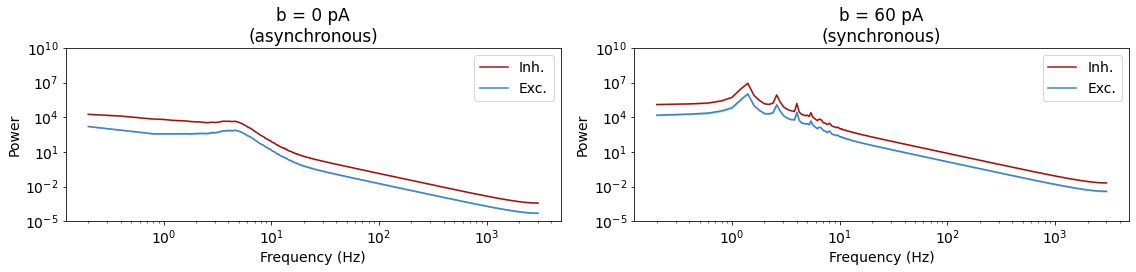

In [21]:
#%% plot power spectrum mean and std over regions

fig, axes = plt.subplots(1,2,figsize=(16,4))
plt.rcParams.update({'font.size': 14})

f_sampling = 1.*len(time_s)/time_s[-1] # time in seconds, f_sampling in Hz
frq = np.fft.fftfreq(len(time_s), 1/f_sampling)

pwr_region_E = []
pwr_region_I = []

for simnum in range(len(bvals)):

    Esig = np.transpose(Ca_exc[simnum])
    Isig = np.transpose(Ca_inh[simnum])

    nnodes = len(Esig)
    for e_reg in range(nnodes):
        pwr_region_E.append(np.abs(np.fft.fft(Esig[e_reg]))**2)
        pwr_region_I.append(np.abs(np.fft.fft(Isig[e_reg]))**2)

    mean_E_Hz = np.mean(pwr_region_E, axis=0)
    mean_I_Hz = np.mean(pwr_region_I, axis=0)

    std_e = np.std(pwr_region_E, axis=0) #std fft between regions
    std_i = np.std(pwr_region_I, axis=0) #std fft between regions

    high_e = mean_E_Hz[frq > 0]+std_e[frq > 0]/np.sqrt(nnodes)
    high_i = mean_I_Hz[frq > 0]+std_i[frq > 0]/np.sqrt(nnodes)

    low_e =  mean_E_Hz[frq > 0]-std_e[frq > 0]/np.sqrt(nnodes)
    low_i =  mean_I_Hz[frq > 0]-std_i[frq > 0]/np.sqrt(nnodes)

    '''plot psds'''
    axes[simnum].loglog(frq[frq > 0], mean_I_Hz[frq > 0], 'darkred', alpha=0.9, label='Inh.')
    axes[simnum].loglog(frq[frq > 0], mean_E_Hz[frq > 0], color='SteelBlue', label='Exc.')
    axes[simnum].fill_between(frq[frq > 0], high_i, low_i, color = 'DarkSalmon', alpha = 0.4)
    axes[simnum].fill_between(frq[frq > 0], high_e, low_e, color = 'DodgerBlue', alpha = 0.4)
    
    axes[simnum].set_xlabel('Frequency (Hz)')
    axes[simnum].set_ylabel('Power')  
    
    for ax in axes.reshape(-1):
        ax.legend()
        ax.set_ylim(10e-6,10e9)

    axes[simnum].set_title('b = {0} pA\n({1})'.format(bvals[simnum],simname[simnum]))
    
    
plt.tight_layout()
plt.show()

### Functional connectivity matrices

In [22]:
## select cortical regions only through a mask:

wdir = os.getcwd()
os.chdir('tvb_model_reference/data/Mouse_512/')
mask = np.load('cortical.npy')
os.chdir(wdir)

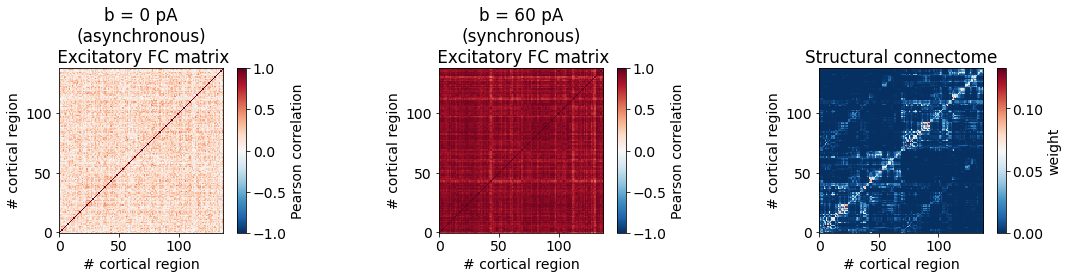

In [23]:

## plot pearson correlation functional connectivity matrices and the strucutural connectome weights:

fig, axes = plt.subplots(1, 3, figsize=(16,4))
plt.rcParams.update({'font.size': 14})

pearson_e = []
for simnum in range(len(bvals)):
    pearson_e.append(np.corrcoef(np.transpose(Ca_exc[simnum][:,mask])))
    im1 = axes[simnum].imshow(pearson_e[simnum], cmap = 'RdBu_r', vmin = -1, vmax = 1, 
           interpolation = 'nearest', origin='lower')
    fig.colorbar(im1, ax=axes[simnum],label='Pearson correlation')    
    axes[simnum].set_title('b = {0} pA\n({1})\n Excitatory FC matrix'.format(bvals[simnum],simname[simnum]))
    
for ax in axes.reshape(-1):
    ax.set_xlabel('# cortical region')
    ax.set_ylabel('# cortical region')
    ax.set_xticks([0,50,100])
    ax.set_yticks([0,50,100])

im2 = axes[2].imshow(simulator.connectivity.weights[mask,:][:,mask], cmap = 'RdBu_r', interpolation = 'nearest', origin='lower')
fig.colorbar(im2, ax=axes[2], label='weight')

axes[2].set_xlabel('# cortical region')
axes[2].set_ylabel('# cortical region') 
axes[2].set_title('Structural connectome')

plt.tight_layout()
plt.show()
